<a href="https://colab.research.google.com/github/SSDivyaRavali/CDS/blob/main/Module4/CNN_Face_Mask_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face Mask Detection using Convolutional Neural Networks

## Objectives

At the end of the miniproject, you will be able to :

* load and extract features of images using ImageDataGenerator

* build the convolutional neural networks

* use the pre-trained models using keras applications

## Introduction

This project uses a Deep Neural Network, more specifically a Convolutional Neural Network, to differentiate between images of people, with masks, without masks and incorrectly placed masks. Manually built and pretrained networks will be used to perform this classification task.

**Face-Mask-Detection-Using-CNN**

* Outbreak of the Coronavirus pandemic has created various changes in the lifestyle of everyone around the world.
* Among these changes, wearing a mask has been very vital to every individual.
* Detection of people who are not wearing masks is a challenge due to the large populations.
* This face mask detection project can be used in schools, hospitals, banks, airports etc as a digitalized scanning tool. 
  - The technique of detecting people’s faces and segregating them into three classes namely the people with masks and people without masks and partial masks is done with the help of image processing and deep learning.
* With the help of this project, a person who is monitoring the face mask status for a particular firm can be seated in a remote area and still monitor efficiently and give instructions accordingly.

![img](https://d2h0cx97tjks2p.cloudfront.net/blogs/wp-content/uploads/sites/2/2020/07/dataset-with-mask-1536x844.png)

## Dataset

The data for this mini-project is collected from various sources including the masked images from internet and general frontal face images considered as without mask. This dataset consists of 5029 train images and 1059 test images with 3 classes `with_mask`, `without_mask` and `partial_mask`

Many people are not correctly wearing their masks due to bad practices, bad behaviors or vulnerability of individuals (e.g., children, old people). For these reasons, several mask wearing campaigns intend to sensitize people about this problem and good practices. In this sense, this work proposes three types of masked face detection dataset; namely, the Correctly Masked Face, the Incorrectly Masked Face and their combination for the global masked face detection. This dataset serves the objective of classifying faces that are: 
  
- Without Mask/ With Mask/ Partial Mask
  
Note that this dataset contains some annotated (artificially generated) masks to augment the 'masked' data category.

## Problem Statement

To build and implement a Convolutional Neural Network model to classify between masked/unmasked/partially masked faces.

## Grading = 10 Points

In [ ]:
#@title Download the data
!wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/MP2_FaceMask_Dataset.zip
!unzip -qq MP2_FaceMask_Dataset.zip
print("Data Downloaded Successfuly!!")

Data Downloaded Successfuly!!


### Import Required packages

In [ ]:
import numpy as np
import PIL
from matplotlib import pyplot as plt
#plt.xkcd()
import glob, os
import pandas as pd
from tensorflow import keras
from keras.applications.vgg16 import VGG16
#from keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense,Dropout,InputLayer
from keras.models import Model, load_model
from keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.optimizers import SGD, Adam
import random
import tensorflow as tf
%load_ext tensorboard

In [ ]:
#keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
TRAINING_DIR = "/content/MP2_FaceMask_Dataset/train/"
VALIDATION_DIR = "/content/MP2_FaceMask_Dataset/test/"
TEST_DIR = "/content/MP2_FaceMask_Dataset/datatest/"

## Data Loading and preprocessing (2 points)

### Analyze the shape of images and distribution of classes

In [ ]:
categories = os.listdir(TRAINING_DIR)
categories

['without_mask', 'with_mask', 'partial_mask']

In [ ]:
#extract the labels for classes
def label_extract():
  #image_size = 100
  image_path=[]
  labels = []
  for category in categories:
    folder_path = os.path.join(TRAINING_DIR,category)
    image_names = os.listdir(folder_path)
    for image_name in image_names:
      try:
        image_path.append(os.path.join(folder_path,image_name))
        labels.append(category)
      except:
        print("Error Loading Image")
  labels = np.array(labels)
  return image_path,labels

In [ ]:
image_path, labels = label_extract()
target = np.array(labels)

JPEG
RGB
(160, 160)


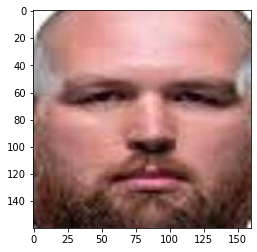

In [ ]:
from PIL import Image
# load the image
image = Image.open(image_path[0])
# summarize some details about the image
print(image.format)
print(image.mode)
print(image.size)
# display the array of pixels as an image
plt.imshow(image)
plt.show()

In [ ]:
# Checking for class bias
def check_target_class_bias():
  unique_labels, Label_count = np.unique(target, return_counts = True)
  print(np.asarray((unique_labels)))
  plt.bar( np.arange(3), Label_count, align='center',color='blue' )
  plt.xlabel('Class')
  plt.ylabel('No of Training data files')
  plt.xlim([-1, 4])

  plt.show()

['partial_mask' 'with_mask' 'without_mask']


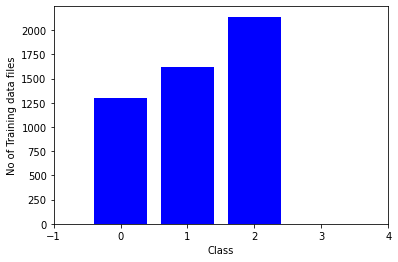

In [ ]:
check_target_class_bias()

### Load the images using ImageDataGenerator

There are two main steps involved in creating the generator.
1. Instantiate ImageDataGenerator with required arguments to create an object
2. Use the `flow_from_directory` command depending on how your data is stored on disk. This is the command that will allow you to generate and get access to batches of data on the fly.

Hint: [link](https://keras.io/api/preprocessing/image/)

In [ ]:
train_datagen = ImageDataGenerator(
        rescale = 1./255,
        shear_range = 0.1,
        zoom_range = [0.8, 1.25],
        brightness_range = [0.5,1],
        height_shift_range = 0.1,
        width_shift_range = 0.1,
        rotation_range = 12,
        horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        TRAINING_DIR,
        target_size=(256, 256),
        batch_size=32,
        class_mode='categorical',color_mode="rgb",
        seed=42)
validation_generator = test_datagen.flow_from_directory(
        VALIDATION_DIR,
        target_size=(256, 256),
        batch_size=32,
        class_mode='categorical',color_mode="rgb",seed=42)


Found 5029 images belonging to 3 classes.
Found 1259 images belonging to 3 classes.


### Visualize the sample images of each class using data generator

Hint: plt.subplot

In [ ]:
#plot a random image from each class
def plot_sample_image():
  f = plt.figure(figsize=(6,6))
  image = {}
  cur_path = TRAINING_DIR
  i = 0
  for image_category in categories:
    s = f.add_subplot(3, 3, i + 1)
    s.axis('Off')
    category_folder_path = os.path.join(TRAINING_DIR,image_category)
    sample_image = random.choice(os.listdir(category_folder_path))
    sample_image_path = os.path.join(category_folder_path,sample_image)
    print(f'sample image = {sample_image_path}')
    image[i]=Image.open(sample_image_path)
    plt.imshow(image[i])
    i += 1

In [ ]:
categories

['without_mask', 'with_mask', 'partial_mask']

sample image = /content/MP2_FaceMask_Dataset/train/without_mask/316.jpg
sample image = /content/MP2_FaceMask_Dataset/train/with_mask/236-with-mask.jpg
sample image = /content/MP2_FaceMask_Dataset/train/partial_mask/51860_Mask_Mouth_Chin.jpg


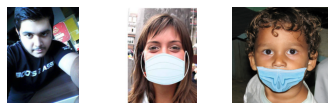

In [ ]:
plot_sample_image()

## Build the CNN model using Keras (4 points)



**Convolutional Neural Network:** A neural network in which at least one layer is a convolutional layer. A typical convolutional neural network consists of some combination of the following layers:

* convolutional layers
* pooling layers
* dense layers


**Conv2D**  

Passing an image with input shape of 3-D and to calculate the output: 

 $O = \frac{n - f + 2p}{s} + 1$

**MaxPool** 

The resulting output, when using the "valid" padding option, has a spatial shape (number of rows or columns) of: 

O = `math.floor`$(\frac{input shape - pool size)}{ strides}) + 1$ (when input shape >= pool size)

The resulting output shape when using the "same" padding option is: 

O = `math.floor`$(\frac{input shape - 1}{strides}) + 1$

by default, stride = None, so stride is same as pool size

Task-flow
* Initialize the network of convolution, maxpooling and dense layers
* Define the optimizer and loss functions
* Fit the model and evaluate the model

In [ ]:
# Create model - best till now
model = Sequential([
                    Conv2D(256, 7, activation="relu", padding="same", input_shape=[256, 256, 3]),
                    MaxPooling2D(2),
                    BatchNormalization(),
                    Conv2D(512, 3, activation="relu", padding="same"),
                    Conv2D(512, 3, activation="relu", padding="same"),
                    MaxPooling2D(2),
                    BatchNormalization(),
                    Conv2D(256, 3, activation="relu", padding="same"),
                    Conv2D(256, 3, activation="relu", padding="same"),
                    MaxPooling2D(2),
                    BatchNormalization(),
                    Conv2D(128, 3, activation="relu", padding="same"),
                    Conv2D(128, 3, activation="relu", padding="same"),
                    MaxPooling2D(2),
                    BatchNormalization(),
                    Flatten(),
                    Dropout(0.2),
                    Dense(64, activation="relu"),
                    Dropout(0.3),
                    Dense(3, activation="softmax")
                    ])

In [ ]:
model.layers[9].variables

[]

In [ ]:
[(var.name, var.trainable) for var in model.layers[2].variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 256)     37888     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 256)    0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 256)    1024      
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 512)     1180160   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 512)     2359808   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 512)      0

In [ ]:
# Compile model
adam = Adam(learning_rate=0.0001)
#model.compile(loss="categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
model.compile(loss="categorical_crossentropy", optimizer=adam, metrics=["accuracy"])

In [ ]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_model-ver11-jo.h5",save_best_only=True)

In [ ]:
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print("\nval/train: {:.2f}".format(logs["val_loss"] / logs["loss"]))

In [ ]:
val_train_ratio_cb = PrintValTrainRatioCallback()
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size
history = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10,
          callbacks=[val_train_ratio_cb,checkpoint_cb,early_stopping_cb])

Epoch 1/10
157/157 [==============================] - ETA: 0s - loss: 0.3969 - accuracy: 0.8651
val/train: 5.12
157/157 [==============================] - 813s 5s/step - loss: 0.3969 - accuracy: 0.8651 - val_loss: 2.0335 - val_accuracy: 0.4912
Epoch 2/10
 28/157 [====>.........................] - ETA: 9:23 - loss: 0.1895 - accuracy: 0.9436

KeyboardInterrupt: ignored

In [ ]:
model = keras.models.load_model("my_model-ver11.h5") # rollback to best model

In [ ]:
from functools import partial
DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")
model3 = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[256, 256, 3]),
    keras.layers.MaxPooling2D(pool_size=2),
    BatchNormalization(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    BatchNormalization(),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    BatchNormalization(),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=3, activation='softmax'),
])

In [ ]:
model2.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_133 (Conv2D)         (None, 256, 256, 64)      9472      
                                                                 
 max_pooling2d_74 (MaxPoolin  (None, 128, 128, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_134 (Conv2D)         (None, 128, 128, 128)     73856     
                                                                 
 conv2d_135 (Conv2D)         (None, 128, 128, 128)     147584    
                                                                 
 max_pooling2d_75 (MaxPoolin  (None, 64, 64, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_136 (Conv2D)         (None, 64, 64, 256)     

In [ ]:
# Compile model
adam = Adam(learning_rate=0.0001)
#model.compile(loss="categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
model2.compile(loss="categorical_crossentropy", optimizer=adam, metrics=["accuracy"])

In [ ]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_model2-ver1.h5",save_best_only=True)

In [ ]:
val_train_ratio_cb = PrintValTrainRatioCallback()
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size
history = model2.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10,
          callbacks=[val_train_ratio_cb,checkpoint_cb,early_stopping_cb])

Epoch 1/10
157/157 [==============================] - ETA: 0s - loss: 0.6853 - accuracy: 0.7098
val/train: 0.39
157/157 [==============================] - 164s 990ms/step - loss: 0.6853 - accuracy: 0.7098 - val_loss: 0.2652 - val_accuracy: 0.9046
Epoch 2/10
157/157 [==============================] - ETA: 0s - loss: 0.4284 - accuracy: 0.8411
val/train: 0.44
157/157 [==============================] - 155s 985ms/step - loss: 0.4284 - accuracy: 0.8411 - val_loss: 0.1894 - val_accuracy: 0.9223
Epoch 3/10
157/157 [==============================] - ETA: 0s - loss: 0.3401 - accuracy: 0.8735
val/train: 0.62
157/157 [==============================] - 154s 980ms/step - loss: 0.3401 - accuracy: 0.8735 - val_loss: 0.2121 - val_accuracy: 0.9239
Epoch 4/10
157/157 [==============================] - ETA: 0s - loss: 0.3068 - accuracy: 0.8913
val/train: 0.53
157/157 [==============================] - 155s 983ms/step - loss: 0.3068 - accuracy: 0.8913 - val_loss: 0.1620 - val_accuracy: 0.9375
Epoch 5/10
1

In [ ]:
model.evaluate(validation_generator)

28/40 [====================>.........] - ETA: 17s - loss: 3.5478 - accuracy: 0.4319

KeyboardInterrupt: ignored

In [ ]:
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.title("model learnigng curve")
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

NameError: ignored

In [ ]:
# Visualize model's training and validation metrics
metric = "accuracy"

plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])

plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()

NameError: ignored

## Transfer learning (4 points)

Transfer learning consists of taking features learned on one problem, and leveraging them on a new, similar problem.

A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task.

The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.

For eg. Using VGG16, we remove the last layer which takes a probability for each of the 1000 classes in the ImageNet and replaces it with a layer that takes 3 probabilities in our case.

### Use the pre-trained models ([VGG16](https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/VGG16) or [ResNet50](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/ResNet50))

* Load the pre-trained model
* Fit and evaluate the data

Hint: [How to use pre-trained model](https://towardsdatascience.com/step-by-step-guide-to-using-pretrained-models-in-keras-c9097b647b29)

#### Expected accuracy: More than 90%

Task-flow
* Initialize the network with the weights of Imagenet
* Fine tune the network by modifying fully connected layers.
* Re-train the model with our problem data

In [ ]:
from keras.applications.vgg16 import VGG16

vgg_model = keras.models.Sequential()

VGG = VGG16(include_top=False, input_shape=(256,256,3))

for layer in VGG.layers:
    layer.trainable = False

vgg_model.add(VGG)
vgg_model.add(Flatten())
vgg_model.add(Dense(256,  activation="relu")),
vgg_model.add(Dense(128,  activation="relu"))
vgg_model.add(Dropout(0.1))
vgg_model.add(Dense(64,  activation="relu"))
vgg_model.add(Dropout(0.2))
vgg_model.add(Dense(3,  activation="softmax"))

vgg_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_8 (Flatten)         (None, 32768)             0         
                                                                 
 dense_19 (Dense)            (None, 128)               4194432   
                                                                 
 dropout_14 (Dropout)        (None, 128)               0         
                                                                 
 dense_20 (Dense)            (None, 64)                8256      
                                                                 
 dropout_15 (Dropout)        (None, 64)                0         
                                                                 
 dense_21 (Dense)            (None, 3)                

In [ ]:
# Compile model
vgg_model.compile(loss="categorical_crossentropy", optimizer=adam, metrics=["accuracy"])

In [ ]:
checkpoint_cb_vgg = keras.callbacks.ModelCheckpoint("vgg_model-ver2-i.h5",save_best_only=True)

In [ ]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size
history = vgg_model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=15,
                    callbacks=[checkpoint_cb_vgg,early_stopping_cb ])

Epoch 1/15
157/157 [==============================] - 103s 655ms/step - loss: 0.3043 - accuracy: 0.8767 - val_loss: 0.0926 - val_accuracy: 0.9655
Epoch 2/15
157/157 [==============================] - 103s 655ms/step - loss: 0.1113 - accuracy: 0.9568 - val_loss: 0.0570 - val_accuracy: 0.9824
Epoch 3/15
157/157 [==============================] - 102s 650ms/step - loss: 0.0903 - accuracy: 0.9688 - val_loss: 0.0538 - val_accuracy: 0.9776
Epoch 4/15
157/157 [==============================] - 102s 652ms/step - loss: 0.0824 - accuracy: 0.9710 - val_loss: 0.0457 - val_accuracy: 0.9800
Epoch 5/15
157/157 [==============================] - 104s 660ms/step - loss: 0.0714 - accuracy: 0.9742 - val_loss: 0.0402 - val_accuracy: 0.9832
Epoch 6/15
157/157 [==============================] - 103s 653ms/step - loss: 0.0642 - accuracy: 0.9770 - val_loss: 0.0376 - val_accuracy: 0.9848
Epoch 7/15
157/157 [==============================] - 103s 652ms/step - loss: 0.0532 - accuracy: 0.9838 - val_loss: 0.0374 -

In [ ]:
from tensorflow.keras.applications import ResNet50

rn_model = keras.models.Sequential()

RN = ResNet50(include_top=False, input_shape=(256,256,3))

for layer in RN.layers[:10]:
    layer.trainable = False

rn_model.add(RN)
rn_model.add(Flatten())
rn_model.add(Dense(3))

rn_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten_4 (Flatten)         (None, 131072)            0         
                                                                 
 dense_5 (Dense)             (None, 3)                 393219    
                                                                 
Total params: 23,980,931
Trainable params: 23,913,923
Non-trainable params: 67,008
_________________________________________________________________


In [ ]:
# Compile model
rn_model.compile(loss="categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

In [ ]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size
rn_model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=5)

Epoch 1/5
157/157 [==============================] - 107s 589ms/step - loss: 6.9270 - accuracy: 0.4257 - val_loss: 6.8321 - val_accuracy: 0.4239
Epoch 2/5
157/157 [==============================] - 91s 580ms/step - loss: 6.8801 - accuracy: 0.4245 - val_loss: 6.8862 - val_accuracy: 0.4223
Epoch 3/5
157/157 [==============================] - 91s 580ms/step - loss: 6.8801 - accuracy: 0.4249 - val_loss: 7.0192 - val_accuracy: 0.4255
Epoch 4/5
157/157 [==============================] - 92s 581ms/step - loss: 6.8898 - accuracy: 0.4247 - val_loss: 6.9883 - val_accuracy: 0.4255
Epoch 5/5
157/157 [==============================] - 91s 579ms/step - loss: 6.8833 - accuracy: 0.4251 - val_loss: 6.8952 - val_accuracy: 0.4239


### Capture the live image using the below code cell and predict

<IPython.core.display.Javascript object>

Saved to photo.jpg


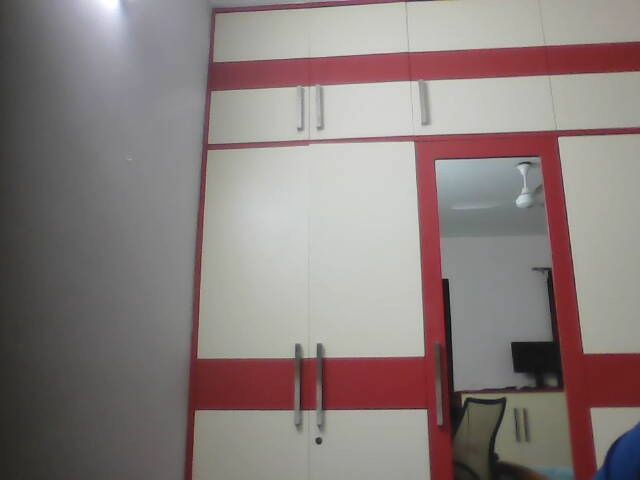

In [ ]:
#@title Capture the photo
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  display(Image(filename))
except Exception as err:
  print(str(err))

After executing above cell and capturing the photo, load the captured photo and predict with model.

**Note:** 
* Convert the image to numpy array and resize to the shape which model accept. 
* Extend the dimension (to 4-D shape) of an image, as the model is trained on a batch of inputs.

In [ ]:
ftest_generator = test_datagen.flow_from_directory(
    "/content/MP2_FaceMask_Dataset/datatest",
    target_size=(256, 256),
    color_mode="rgb",
    batch_size=1,
    class_mode=None,
    shuffle=False,
    seed=42
)

Found 2 images belonging to 2 classes.


In [ ]:
STEP_SIZE_TEST = ftest_generator.n//ftest_generator.batch_size
ftest_generator.reset()
pred = vgg_model.predict(ftest_generator,steps = STEP_SIZE_TEST,verbose=1)

2/2 [==============================] - 0s 6ms/step


In [ ]:
predicted_class_indices = np.argmax(pred,axis=1)
predicted_class_indices

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [ ]:

filenames = ftest_generator.filenames
results = pd.DataFrame({"img_path":filenames,"label":predictions})
results
#results.to_csv("Sample_Submission.csv",index=False)

,img_path,label
0,test/face-photo.jpeg,without_mask
1,test/mask.jpeg,with_mask


### Instructions for preparing Kaggle competition predictions

Important: Refer the [Kaggle Team Creation Instructions Doc](https://drive.google.com/file/d/1NwUrRFpGuSagueS_BwGNq4upnyagTDxb/view?usp=sharing) 

* Load the image paths from Kaggle testset using `glob`
* Read the Images using `PIL.Image.open` and resize to required shape.
* Get the predictions using trained model and prepare a csv file
  - FC layer of DeepNet model gives output for each class, consider the maximum value among all classes as prediction using `np.argmax`.
* Predictions (csv) file should contain 2 columns as Sample_Submission.csv
  - First column is the img_path which is considered as index
  - Second column is prediction in decoded form (for eg. with_mask, partial_mask, without_mask).



In [ ]:
#load the test data from kaggle
TEST_DIR = "/content/MP2_FaceMask_Dataset/FaceMask_Kaggle_test/"
kaggle_test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(256, 256),
    color_mode="rgb",
    batch_size=1,
    class_mode=None,
    shuffle=False,
    seed=42)

STEP_SIZE_TEST = kaggle_test_generator.n//kaggle_test_generator.batch_size
kaggle_test_generator.reset()
pred = model2.predict(kaggle_test_generator,steps=STEP_SIZE_TEST,verbose=1)

Found 660 images belonging to 2 classes.
660/660 [==============================] - 8s 12ms/step


In [ ]:
np.array(class_names)[pred]

In [ ]:
#make prediections
predicted_class_indices = np.argmax(pred,axis=1)
predicted_class_indices

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [ ]:
#create data into submission csv
filenames = k_test_generator.filenames
results = pd.DataFrame({"img_path":filenames,"label":predictions})
results.to_csv("Sample_Submission.csv",index=False)

### Report Analysis

- Compare the accuracies for the Pre-trained vs CNN models
- What process was followed to tune the hyperparameters?
- Which model detects the mask/no mask/ partial mask more accurately with the live pictures?
- Discuss the confusion matrix in terms of the misclassifications

Tensorboard callback is responsible for logging events such as Activation Histograms, Metrics Summary Plots, Profiling and Training Graph Visualizations

# Tensorboard

In [ ]:
root_logdir = os.path.join(os.curdir, "my_logs")

In [ ]:
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir

'./my_logs/run_2021_11_28-10_26_11'

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10,
          callbacks=[val_train_ratio_cb,checkpoint_cb,early_stopping_cb])

Epoch 1/10
139/157 [=========================>....] - ETA: 1:54 - loss: 0.3847 - accuracy: 0.8754

In [ ]:
# you can load TensorBoard's Jupyter extension and run it like this
from tensorflow.keras.callbacks import TensorBoard
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

In [ ]:
run_logdir2 = get_run_logdir()
run_logdir2

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.load_model("my_keras_model.h5") # rollback to best model

In [ ]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir2)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

In [ ]:
from tensorflow.keras.callbacks import TensorBoard
#load in the TensorBoard notebook extension and create a variable pointing to the log folder
%load_ext tensorboard
log_folder = 'logs'
# %reload_ext tensorboard
#!rm -rf /logs/  #to clear the current logs so that you can write fresh ones to the folder. 

In [ ]:
#to specify the TensorBoard callback during the model’s fit method.
# create the TensorBoard callback and specify the log directory using log_dir.
callbacks = [TensorBoard(log_dir=log_folder,
                         histogram_freq=1,
                         write_graph=True,
                         write_images=True,
                         update_freq='epoch',
                         profile_batch=2,
                         embeddings_freq=1)]

In [ ]:
model.fit(X_train, y_train,
          epochs=10,
          validation_split=0.2,
          callbacks=callbacks)

train the CNN and regularly log the confusion matrix during the process. Using the below code, you will create a Keras TensorBoard callback to log basic metrics.

In [ ]:
logdir = "logs/image/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir = logdir, histogram_freq = 1)
file_writer_cm = tf.summary.create_file_writer(logdir + '/cm')

In [ ]:
def log_confusion_matrix(epoch, logs):
    
    # Use the model to predict the values from the test_images.
    test_pred_raw = model.predict(test_images)
    
    test_pred = np.argmax(test_pred_raw, axis=1)
    
    # Calculate the confusion matrix using sklearn.metrics
    cm = sklearn.metrics.confusion_matrix(test_labels, test_pred)
    
    figure = plot_confusion_matrix(cm, class_names=class_names)
    cm_image = plot_to_image(figure)
    
    # Log the confusion matrix as an image summary.
    with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)

In [ ]:
cm_callback = keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)